In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# # Regression Metrics
from sklearn.metrics import r2_score,mean_squared_error

#visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# # saving/loading trained model with pickle
import pickle

# selecting common working idrectory to allow use of pre_processing.py
import os
os.chdir('/Users/DE7/Desktop/LearningPython/XYZ-Corp')
# bespoke cleaning and data_split functions
from pre_processing import pre_processing, data_split

# saving trained model with pickle
import pickle

In [2]:
# Load individual classifiers
best_rfr = pickle.load(open('regression_problem/saved_models/random_forest_regressor.sav', 'rb'))

# Loading common test data
X_test = pd.read_csv('regression_problem/regression_test_data/X_test.csv', sep = '|').drop('Unnamed: 0', axis = 1)
y_test = np.ravel(pd.read_csv('regression_problem/regression_test_data/y_test.csv', sep = '|').drop('Unnamed: 0', axis = 1))

# Loading the data - for defaulted loans only to review their interest rates
clean_data, feature_list = pre_processing('data/XYZCorp_LendingData.txt')
_, X_defauled, _, y_defaulted = data_split(clean_data, feature_list, problem = 'regression-review')

Test data score:

In [3]:
y_pred_rf = best_rfr.predict(X_test)
print(r2_score(y_test, y_pred_rf))
print(mean_squared_error(y_test, y_pred_rf))

0.9932741499429295
0.11546069699464463


Defaulted data only score:

In [4]:
y_defaulted_pred = best_rfr.predict(X_defauled)
print(r2_score(y_defaulted, y_defaulted_pred))
r2_score(y_defaulted, y_defaulted_pred)
print(mean_squared_error(y_defaulted, y_defaulted_pred))

0.9177610032921342
1.4398845754907423


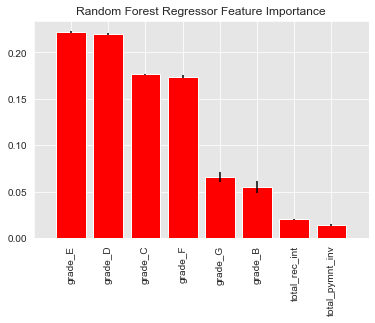

In [5]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
skplt.estimators.plot_feature_importances(best_rfr, feature_names=X_test.columns,
                                         title="Random Forest Regressor Feature Importance",
                                         x_tick_rotation=90,
                                         max_num_features=8)
plt.savefig("regression_problem/visualizations/Feature_importances_rfr.png")

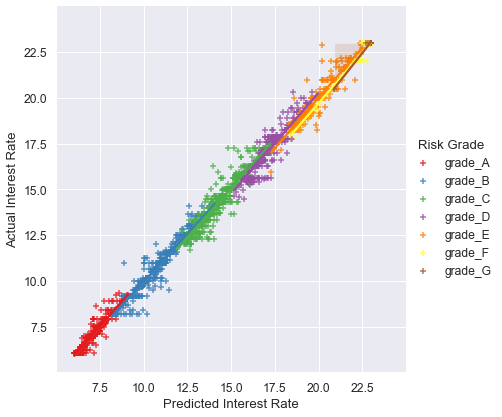

<Figure size 576x648 with 0 Axes>

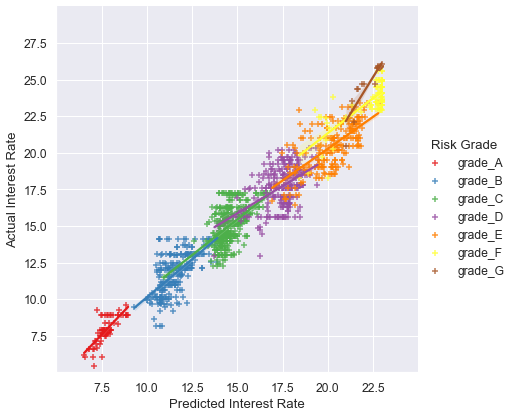

In [6]:
def get_grade(row):
    grade = ['grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
    for ind in grade:
        if row[ind]==1:
            return ind

X_test['Risk Grade'] = X_test.apply(get_grade, axis=1).fillna('grade_A')
X_defauled['Risk Grade'] = X_defauled.apply(get_grade, axis=1).fillna('grade_A')        
        
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
df_test = pd.DataFrame({'y_pred':y_pred_rf,
                   'y_test':y_test,
                   'Risk Grade':X_test['Risk Grade']}).sort_values('Risk Grade')

df_defaulted = pd.DataFrame({'y_pred':y_defaulted_pred,
                   'y_test':y_defaulted,
                   'Risk Grade':X_defauled['Risk Grade']}).sort_values('Risk Grade')

sns.set(font_scale=1.1)
plot = sns.lmplot(x="y_pred", y="y_test", palette="Set1", 
                 hue='Risk Grade',hue_order = ['grade_A','grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'],ci=75,
                 data=df_test.sample(frac=0.025,random_state=44), markers = '+', height = 6,legend=True)
plt.plot([5, 5], [25, 25], linewidth=2)
plot = (plot.set_axis_labels("Predicted Interest Rate", "Actual Interest Rate")
      .set(xlim=(5, 25), ylim=(5, 25),
           xticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5], yticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5]))
plot.figure.savefig("regression_problem/visualizations/Test_data_interest_rate_distribution.png")


fig = plt.figure(figsize=(8,9))
plot = sns.lmplot(x="y_pred", y="y_test", palette="Set1",
                 hue='Risk Grade',hue_order = ['grade_A','grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'],ci=75,
                 data=df_defaulted.sample(frac=0.045,random_state=52), markers = '+', height = 6)
plt.plot([5, 5], [25, 25], linewidth=2)
plot = (plot.set_axis_labels("Predicted Interest Rate", "Actual Interest Rate")
      .set(xlim=(5, 25), ylim=(5, 30),
           xticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5], yticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5,25, 27.5]))
plot.figure.savefig("regression_problem/visualizations/Defaulted_data_interest_rate_distribution.png")

In [7]:
def interest_offset(y_pred, y_test, review_margin = 0.5):
    df = pd.DataFrame({'y_pred':y_pred,
                   'y_test':y_test})
    df['interest_diff'] = df['y_test']-df['y_pred']
    df['interest_diff_ind'] = df['interest_diff']>review_margin
    return df

In [8]:
def double_interest_offset(y_pred, y_test):
    df = pd.DataFrame({'y_pred':y_pred,
                   'y_test':y_test})
    df['interest_diff'] = df['y_test']-df['y_pred']
    df['interest_diff_ind1'] = df['interest_diff']>1.0
    df['interest_diff_ind2'] = df['interest_diff']>2.0
    df['interest_diff_ind'] = df['interest_diff_ind1']
    
    conditions = [df['interest_diff_ind2'], df['interest_diff_ind1'], True]
    values = ['over 2.0%', 'over 1.0%', 'within 1.0%']
    df['interest_margin'] = np.select(conditions, values)
    
    return df

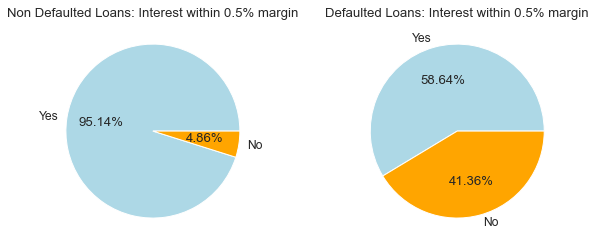

In [9]:
df_test = interest_offset(y_pred_rf, y_test, review_margin = 0.5)
df_defaulted = interest_offset(y_defaulted_pred, y_defaulted, review_margin = 0.5)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
df_test[['interest_diff_ind']].value_counts().plot(kind='pie',labels=['Yes','No'],title='Non Defaulted Loans: Interest within 0.5% margin',autopct='%.2f%%', ax=ax1,colors = ['lightblue', 'orange'], label="")
df_defaulted[['interest_diff_ind']].value_counts().plot(kind='pie',labels=['Yes','No'],title='Defaulted Loans: Interest within 0.5% margin',autopct='%.2f%%', ax=ax2,colors = ['lightblue', 'orange'], label="")
fig.savefig('regression_problem/visualizations/interest_within_prediction_margin_1.png')

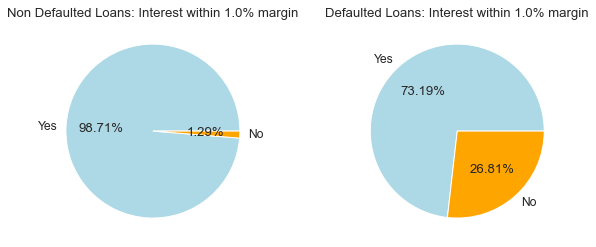

In [10]:
df_test = interest_offset(y_pred_rf, y_test, review_margin = 1.0)
df_defaulted = interest_offset(y_defaulted_pred, y_defaulted, review_margin = 1.0)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
df_test[['interest_diff_ind']].value_counts().plot(kind='pie',labels=['Yes','No'],title='Non Defaulted Loans: Interest within 1.0% margin',autopct='%.2f%%', ax=ax1,colors = ['lightblue', 'orange'], label="")
df_defaulted[['interest_diff_ind']].value_counts().plot(kind='pie',labels=['Yes','No'],title='Defaulted Loans: Interest within 1.0% margin',autopct='%.2f%%', ax=ax2,colors = ['lightblue', 'orange'], label="")
fig.savefig('regression_problem/visualizations/interest_within_prediction_margin_2.png')

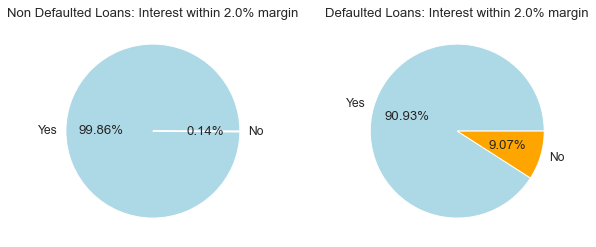

In [11]:
df_test = interest_offset(y_pred_rf, y_test, review_margin = 2.0)
df_defaulted = interest_offset(y_defaulted_pred, y_defaulted, review_margin = 2.0)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
df_test[['interest_diff_ind']].value_counts().plot(kind='pie',labels=['Yes','No'],title='Non Defaulted Loans: Interest within 2.0% margin',autopct='%.2f%%', ax=ax1,colors = ['lightblue', 'orange'], label="")
df_defaulted[['interest_diff_ind']].value_counts().plot(kind='pie',labels=['Yes','No'],title='Defaulted Loans: Interest within 2.0% margin',autopct='%.2f%%', ax=ax2,colors = ['lightblue', 'orange'], label="")
fig.savefig('regression_problem/visualizations/interest_within_prediction_margin_3.png')

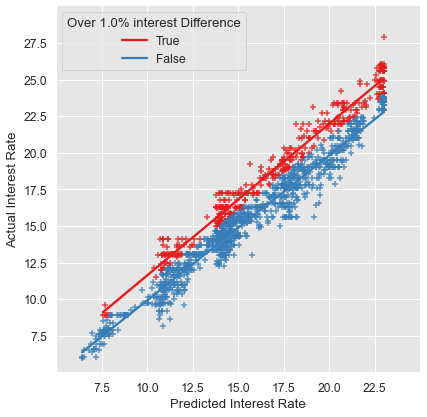

In [12]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
df_defaulted = interest_offset(y_defaulted_pred, y_defaulted, review_margin = 1.0)
plot = sns.lmplot(x="y_pred", y="y_test", palette="Set1",hue ="interest_diff_ind" , data=df_defaulted.sample(frac=0.055,random_state=122), markers = '+', height = 6, hue_order = [True, False], legend = False)
plot = (plot.set_axis_labels("Predicted Interest Rate", "Actual Interest Rate")
      .set(xlim=(5, 25), ylim=(5, 30),
           xticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5], yticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5,25, 27.5]))
plt.legend(title="Over 1.0% interest Difference", loc='upper left', labels=['True', 'False'])
plot.figure.savefig("regression_problem/visualizations/Defaulted_data_loans_to_review_1.png")

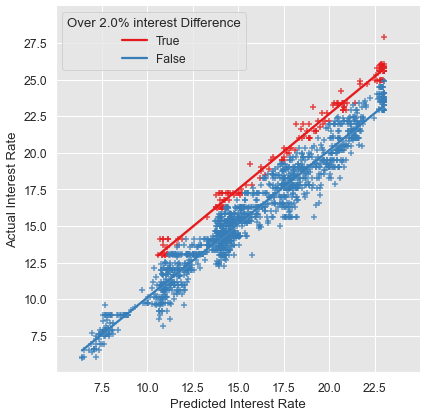

In [13]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
df_defaulted = interest_offset(y_defaulted_pred, y_defaulted, review_margin = 2.0)
plot = sns.lmplot(x="y_pred", y="y_test", palette="Set1",hue ="interest_diff_ind" , data=df_defaulted.sample(frac=0.055,random_state=122), markers = '+', height = 6, hue_order = [True, False], legend = False)
plot = (plot.set_axis_labels("Predicted Interest Rate", "Actual Interest Rate")
      .set(xlim=(5, 25), ylim=(5, 30),
           xticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5], yticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5,25, 27.5]))
plt.legend(title="Over 2.0% interest Difference", loc='upper left', labels=['True', 'False'])
plot.figure.savefig("regression_problem/visualizations/Defaulted_data_loans_to_review_2.png")

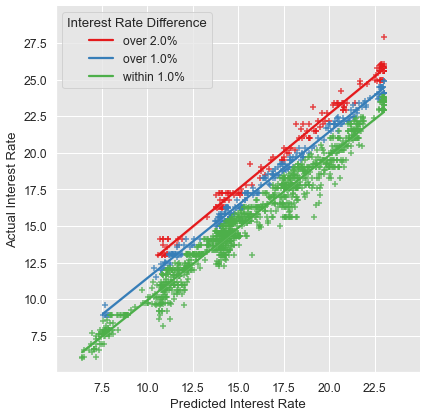

In [14]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
df_defaulted = double_interest_offset(y_defaulted_pred, y_defaulted)
plot = sns.lmplot(x="y_pred", y="y_test", palette="Set1",hue ="interest_margin" , data=df_defaulted.sample(frac=0.055,random_state=122), 
                  markers = '+', height = 6, hue_order = ['over 2.0%', 'over 1.0%', 'within 1.0%'], legend = False)
plot = (plot.set_axis_labels("Predicted Interest Rate", "Actual Interest Rate")
      .set(xlim=(5, 25), ylim=(5, 30), xticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5], yticks=[7.5, 10, 12.5, 15, 17.5, 20, 22.5,25, 27.5]))

plt.legend(title="Interest Rate Difference", loc='upper left', labels=['over 2.0%', 'over 1.0%', 'within 1.0%'])
plot.figure.savefig("regression_problem/visualizations/Defaulted_data_loans_to_review_3.png")